In [79]:
%matplotlib inline
import hashlib
import os
import requests
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import d2l.torch as d2l

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [80]:
DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [81]:
# 下载数据
def download(name, cache_dir=os.path.join('..', 'data')):
    assert name in DATA_HUB, f'{name} is not in DATA_HUB'
    url, sha1_res = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    # 已经存在需要下载的文件
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        # 读取文件得到对应哈希码
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1024 * 1024)
                if not data:
                    break
                sha1.update(data)
            if sha1.hexdigest() == sha1_res: # 保存的文件没有被篡改
                return fname
    print(f'正在下载数据...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [82]:
# 数据预处理：特征归一化，缺失值处理（用0填充），类别特征独热编码
all_features = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]], axis=0)
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / x.std()
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

all_features = pd.get_dummies(all_features, dummy_na=True)

In [83]:
train_num = len(train_data)
train_features = torch.tensor(all_features[:train_num].values, dtype=torch.float32)
test_features = torch.tensor(all_features[train_num:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [84]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    return nn.Sequential(nn.Linear(in_features, 1))

def log_rmse(y_pred, y):
    clipped_preds = torch.clamp(y_pred, 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(y)))
    return rmse.item()


In [88]:
def train(net, updater, train_features, train_labels, test_features, test_labels, batch_size, num_epochs):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size=batch_size, is_train=True)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y)
            updater.zero_grad()
            l.backward()
            updater.step()
    
        train_ls.append(log_rmse(net(train_features), train_labels))
        if test_features is not None:
            test_ls.append(log_rmse(net(test_features), test_labels))
    return train_ls, test_ls

In [86]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    X_train, y_train = None, None
    num = X.shape[0] // k
    for j in range(k):
        idx = slice(j * num, (j + 1) * num)
        X_part, y_part = X[idx], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train == None:
            X_train, y_train = X_part, y_part
        else:
            X_train, y_train = torch.concat([X_train, X_part], dim=0), torch.concat([y_train, y_part], dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, train_features, train_labels, learning_rate, weight_decay, batch_size, num_epochs):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, train_features, train_labels)
        net = get_net()
        updater = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train_ls, valid_ls = train(net, updater,*data, batch_size=batch_size, num_epochs=num_epochs)

        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim= [1, num_epochs], legend=['train', 'X=valid'], yscale='log')
        
        print(f'折{i}: 训练损失-{float(train_ls[-1]):f}, 验证损失-{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折0: 训练损失-0.170330, 验证损失-0.157149
折1: 训练损失-0.162281, 验证损失-0.189989
折2: 训练损失-0.163691, 验证损失-0.168560
折3: 训练损失-0.168094, 验证损失-0.154890
折4: 训练损失-0.163656, 验证损失-0.182824
平均训练损失：0.16561033725738525, 验证损失：0.17068235874176024


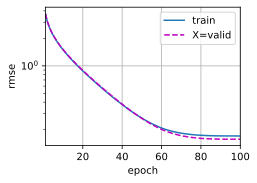

In [87]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k=k, train_features=train_features, train_labels=train_labels, 
                          learning_rate=lr, weight_decay=weight_decay, 
                          batch_size=batch_size, num_epochs=num_epochs)
print(f'平均训练损失：{train_l}, 验证损失：{valid_l}')

In [95]:
def train_and_pred(train_features, train_labels, test_features, test_data, learning_rate, weight_decay, num_epochs, batch_size):
    net = get_net()
    updater = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_l, _ = train(net, updater, train_features=train_features, train_labels=train_labels,
                       test_features=None, test_labels=None, 
                       batch_size=batch_size, num_epochs=num_epochs)
    d2l.plot(np.arange(1, num_epochs + 1), [train_l], xlabel='epoch',
             ylabel='rmse', legend=['train'], xlim=[1, num_epochs],yscale= 'log')
    
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)


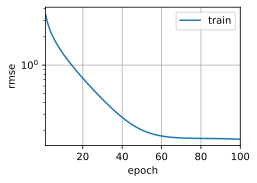

In [96]:
train_and_pred(train_features, train_labels, test_features, test_data, 
               lr, weight_decay, num_epochs, batch_size)